<a href="https://colab.research.google.com/github/NJain121442/course2020/blob/master/homework_4_Nikita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
pip install dgl

In [41]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx

## Homework 4 - Generative Models of graphs

first lets introduce our dataset, the "flower graphs" dataset


In [42]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        filelist = glob.glob(path+'/*.json')
        
        self.graphs = []
        for fname in tqdm(filelist):
            with open(fname) as jfile:
                graph = nx.node_link_graph(json.load(jfile))
                g = dgl.DGLGraph()
                g.from_networkx(graph)
                
                self.graphs.append(g)
        
        
    def __len__(self):
       
        return len(self.graphs)


    def __getitem__(self, idx):
        
    
        return self.graphs[idx]

In [43]:
!wget -O flower_graphs.zip  https://www.dropbox.com/s/fnu6t4s6g5w0fal/flower_graphs.zip?dl=0

--2020-07-10 15:18:56--  https://www.dropbox.com/s/fnu6t4s6g5w0fal/flower_graphs.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnu6t4s6g5w0fal/flower_graphs.zip [following]
--2020-07-10 15:18:56--  https://www.dropbox.com/s/raw/fnu6t4s6g5w0fal/flower_graphs.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8f23017f2248303143c8b844e2.dl.dropboxusercontent.com/cd/0/inline/A7RTna-LbjIv2wsQRwIN_Ll29OtgI_I1p4RaatXuTtdhI9zfZVriJPjs_MOgX3-Xl9XI3MxMvYQU0_GTBNqIzlqZUZf4RxKBjxBzMaP47HIIYkN4DFJejBe0naCR4am3_Ik/file# [following]
--2020-07-10 15:18:57--  https://uc8f23017f2248303143c8b844e2.dl.dropboxusercontent.com/cd/0/inline/A7RTna-LbjIv2wsQRwIN_Ll29OtgI_I1p4RaatXuTtdhI9zfZVriJPjs_MOgX3-Xl9XI3MxMvYQU0_GTBNqIzlqZUZf4Rx

In [44]:
!unzip /content/flower_graphs.zip -d /content

Archive:  /content/flower_graphs.zip
replace /content/flower_graphs/graph_54.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/flower_graphs/graph_54.json  
  inflating: /content/flower_graphs/graph_42.json  
  inflating: /content/flower_graphs/graph_15.json  
  inflating: /content/flower_graphs/graph_39.json  
  inflating: /content/flower_graphs/graph_58.json  
  inflating: /content/flower_graphs/graph_19.json  
  inflating: /content/flower_graphs/graph_62.json  
  inflating: /content/flower_graphs/graph_35.json  
  inflating: /content/flower_graphs/graph_23.json  
  inflating: /content/flower_graphs/graph_7.json  
  inflating: /content/flower_graphs/graph_22.json  
  inflating: /content/flower_graphs/graph_6.json  
  inflating: /content/flower_graphs/graph_34.json  
  inflating: /content/flower_graphs/.DS_Store  
  inflating: /content/__MACOSX/flower_graphs/._.DS_Store  
  inflating: /content/flower_graphs/graph_63.json  
  inflating: /content/flower_graphs/graph_18

In [45]:
graph_ds = CustomDataset('/content/flower_graphs/')

In [72]:
len(graph_ds)

64

Its a pretty simple dataset, just an "inner circle" plus some short arms,
no node features or edge features

In [46]:
import matplotlib.pyplot as plt

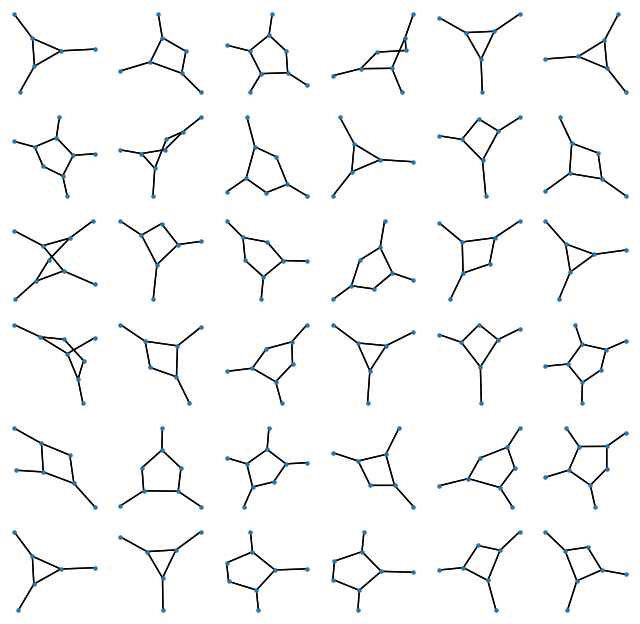

In [47]:
N = 6

fig,ax = plt.subplots(N,N,figsize=(8,8),dpi=100)


idxs = np.random.permutation(np.arange(len(graph_ds)))

for i in range(N):
    for j in range(N):
        idx = idxs[i*N+j]
        nx.draw( graph_ds[idx].to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()

## your goal is to train a network that will generate graphs like these

based on what you saw in the lecture - you need to turn the graph into a sequence of "actions"

the tutorial we are following
https://docs.dgl.ai/en/0.4.x/tutorials/models/3_generative_model/5_dgmg.html

uses a sequence of integers, that represent different things based on where we are in the sequence

the function below converts a graph to a sequence in the right format

In [48]:
def get_decision_sequence(g):
    
    nodes = np.random.permutation( g.nodes() )
    
    edge_start, edge_end = g.edges()
    
    elist = np.random.permutation([(es,ee) for es,ee in zip(edge_start, edge_end)])
    
    added_nodes = []
    added_edges = []
    
    decision_sequence = []

    for node_idx in nodes:
        decision_sequence.append(0)  # Add node
        
        added_nodes.append(node_idx)
        
        edges_from_node = [e for e in elist if e[0]==node_idx]
        
        for e in edges_from_node:
            
            if e[1] not in added_nodes:
                continue
            elif (e[1],e[0]) in added_edges:
                continue
            decision_sequence.append(0)  # Add edge
            dst = np.where(added_nodes==e[1])[0][0]
            decision_sequence.append(dst)  # Set destination to be previous node.
            added_edges.append((e[0],e[1]))
            
        decision_sequence.append(1)  # Stop adding edge
    decision_sequence.append(1)  # Stop adding node

    return decision_sequence


In [49]:
get_decision_sequence( graph_ds[5] )

[0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 5,
 1,
 0,
 0,
 0,
 0,
 5,
 1,
 0,
 0,
 7,
 1,
 1]

## after you copy-paste all the following code:

In [50]:
class DGMGSkeleton(nn.Module):
    def __init__(self, v_max):
        """
        Parameters
        ----------
        v_max: int
            Max number of nodes considered
        """
        super(DGMGSkeleton, self).__init__()

        # Graph configuration
        self.v_max = v_max

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""
        return NotImplementedError

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""
        return NotImplementedError

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""
        return NotImplementedError

    def forward_train(self, actions):
        """Forward at training time. It records the probability
        of generating a ground truth graph following the actions."""
        return NotImplementedError

    def forward_inference(self):
        """Forward at inference time.
        It generates graphs on the fly."""
        return NotImplementedError

    def forward(self, actions=None):
        # The graph you will work on
        self.g = dgl.DGLGraph()

        # If there are some features for nodes and edges,
        # zero tensors will be set for those of new nodes and edges.
        self.g.set_n_initializer(dgl.frame.zero_initializer)
        self.g.set_e_initializer(dgl.frame.zero_initializer)

        if self.training:
            return self.forward_train(actions=actions)
        else:
            return self.forward_inference()
    
def forward_inference(self):
    stop = self.add_node_and_update()
    while (not stop) and (self.g.number_of_nodes() < self.v_max + 1):
        num_trials = 0
        to_add_edge = self.add_edge_or_not()
        while to_add_edge and (num_trials < self.g.number_of_nodes() - 1):
            self.choose_dest_and_update()
            num_trials += 1
            to_add_edge = self.add_edge_or_not()
        stop = self.add_node_and_update()

    return self.g
    
def forward_train(self, actions):
    self.prepare_for_train()
    """
    - actions: list
        - Contains a_1, ..., a_T described above
    - self.prepare_for_train()
        - Initializes self.action_step to be 0, which will get
          incremented by 1 every time it is called.
        - Initializes objects recording log p(a_t|a_1,...a_{t-1})

    Returns
    -------
    - self.get_log_prob(): log p(a_1, ..., a_T)
    """
  

    stop = self.add_node_and_update(a=actions[self.action_step])
    while not stop:
        to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
        while to_add_edge:
            self.choose_dest_and_update(a=actions[self.action_step])
            to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
        stop = self.add_node_and_update(a=actions[self.action_step])

    return self.get_log_prob()

import torch    
class GraphEmbed(nn.Module):
    def __init__(self, node_hidden_size):
        super(GraphEmbed, self).__init__()

        # Setting from the paper
        self.graph_hidden_size = 2 * node_hidden_size

        # Embed graphs
        self.node_gating = nn.Sequential(
            nn.Linear(node_hidden_size, 1),
            nn.Sigmoid()
        )
        self.node_to_graph = nn.Linear(node_hidden_size,
                                       self.graph_hidden_size)

    def forward(self, g):
        if g.number_of_nodes() == 0:
            return torch.zeros(1, self.graph_hidden_size)
        else:
            # Node features are stored as hv in ndata.
            hvs = g.ndata['hv']
            return (self.node_gating(hvs) *
                    self.node_to_graph(hvs)).sum(0, keepdim=True)

from functools import partial    
class GraphProp(nn.Module):
    def __init__(self, num_prop_rounds, node_hidden_size):
        super(GraphProp, self).__init__()

        self.num_prop_rounds = num_prop_rounds

        # Setting from the paper
        self.node_activation_hidden_size = 2 * node_hidden_size

        message_funcs = []
        node_update_funcs = []
        self.reduce_funcs = []

        for t in range(num_prop_rounds):
            # input being [hv, hu, xuv]
            message_funcs.append(nn.Linear(2 * node_hidden_size + 1,
                                           self.node_activation_hidden_size))

            self.reduce_funcs.append(partial(self.dgmg_reduce, round=t))
            node_update_funcs.append(
                nn.GRUCell(self.node_activation_hidden_size,
                           node_hidden_size))

        self.message_funcs = nn.ModuleList(message_funcs)
        self.node_update_funcs = nn.ModuleList(node_update_funcs)

    def dgmg_msg(self, edges):
        """For an edge u->v, return concat([h_u, x_uv])"""
        return {'m': torch.cat([edges.src['hv'],
                                edges.data['he']],
                               dim=1)}

    def dgmg_reduce(self, nodes, round):
        hv_old = nodes.data['hv']
        m = nodes.mailbox['m']
        message = torch.cat([
            hv_old.unsqueeze(1).expand(-1, m.size(1), -1), m], dim=2)
        node_activation = (self.message_funcs[round](message)).sum(1)

        return {'a': node_activation}

    def forward(self, g):
        if g.number_of_edges() > 0:
            for t in range(self.num_prop_rounds):
                g.update_all(message_func=self.dgmg_msg,
                             reduce_func=self.reduce_funcs[t])
                g.ndata['hv'] = self.node_update_funcs[t](
                     g.ndata['a'], g.ndata['hv'])   

import torch.nn.functional as F
from torch.distributions import Bernoulli
def bernoulli_action_log_prob(logit, action):
    """Calculate the log p of an action with respect to a Bernoulli
    distribution. Use logit rather than prob for numerical stability."""
    if action == 0:
        return F.logsigmoid(-logit)
    else:
        return F.logsigmoid(logit)

class AddNode(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddNode, self).__init__()

        self.graph_op = {'embed': graph_embed_func}

        self.stop = 1
        self.add_node = nn.Linear(graph_embed_func.graph_hidden_size, 1)

        # If to add a node, initialize its hv
        self.node_type_embed = nn.Embedding(1, node_hidden_size)
        self.initialize_hv = nn.Linear(node_hidden_size + \
                                       graph_embed_func.graph_hidden_size,
                                       node_hidden_size)

        self.init_node_activation = torch.zeros(1, 2 * node_hidden_size)

    def _initialize_node_repr(self, g, node_type, graph_embed):
        """Whenver a node is added, initialize its representation."""
        num_nodes = g.number_of_nodes()
        hv_init = self.initialize_hv(
            torch.cat([
                self.node_type_embed(torch.LongTensor([node_type])),
                graph_embed], dim=1))
        g.nodes[num_nodes - 1].data['hv'] = hv_init
        g.nodes[num_nodes - 1].data['a'] = self.init_node_activation

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)

        logit = self.add_node(graph_embed)
        prob = torch.sigmoid(logit)

        if not self.training:
            action = Bernoulli(prob).sample().item()
        stop = bool(action == self.stop)

        if not stop:
            g.add_nodes(1)
            self._initialize_node_repr(g, action, graph_embed)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)

            self.log_prob.append(sample_log_prob)

        return stop   
class AddEdge(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddEdge, self).__init__()

        self.graph_op = {'embed': graph_embed_func}
        self.add_edge = nn.Linear(graph_embed_func.graph_hidden_size + \
                                  node_hidden_size, 1)

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)
        src_embed = g.nodes[g.number_of_nodes() - 1].data['hv']

        logit = self.add_edge(torch.cat(
            [graph_embed, src_embed], dim=1))
        prob = torch.sigmoid(logit)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)
            self.log_prob.append(sample_log_prob)
        else:
            action = Bernoulli(prob).sample().item()

        to_add_edge = bool(action == 0)
        return to_add_edge

from torch.distributions import Categorical
class ChooseDestAndUpdate(nn.Module):
    def __init__(self, graph_prop_func, node_hidden_size):
        super(ChooseDestAndUpdate, self).__init__()

        self.graph_op = {'prop': graph_prop_func}
        self.choose_dest = nn.Linear(2 * node_hidden_size, 1)

    def _initialize_edge_repr(self, g, src_list, dest_list):
        # For untyped edges, only add 1 to indicate its existence.
        # For multiple edge types, use a one-hot representation
        # or an embedding module.
        edge_repr = torch.ones(len(src_list), 1)
        g.edges[src_list, dest_list].data['he'] = edge_repr

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, dest):
        src = g.number_of_nodes() - 1
        possible_dests = range(src)

        src_embed_expand = g.nodes[src].data['hv'].expand(src, -1)
        possible_dests_embed = g.nodes[possible_dests].data['hv']

        dests_scores = self.choose_dest(
            torch.cat([possible_dests_embed,
                       src_embed_expand], dim=1)).view(1, -1)
        dests_probs = F.softmax(dests_scores, dim=1)

        if not self.training:
            dest = Categorical(dests_probs).sample().item()

        if not g.has_edge_between(src, dest):
            # For undirected graphs, add edges for both directions
            # so that you can perform graph propagation.
            src_list = [src, dest]
            dest_list = [dest, src]

            g.add_edges(src_list, dest_list)
            self._initialize_edge_repr(g, src_list, dest_list)

            self.graph_op['prop'](g)

        if self.training:
            if dests_probs.nelement() > 1:
                self.log_prob.append(
                    F.log_softmax(dests_scores, dim=1)[:, dest: dest + 1])
class DGMG(DGMGSkeleton):
    def __init__(self, v_max, node_hidden_size,
                 num_prop_rounds):
        super(DGMG, self).__init__(v_max)

        # Graph embedding module
        self.graph_embed = GraphEmbed(node_hidden_size)

        # Graph propagation module
        self.graph_prop = GraphProp(num_prop_rounds,
                                    node_hidden_size)

        # Actions
        self.add_node_agent = AddNode(
            self.graph_embed, node_hidden_size)
        self.add_edge_agent = AddEdge(
            self.graph_embed, node_hidden_size)
        self.choose_dest_agent = ChooseDestAndUpdate(
            self.graph_prop, node_hidden_size)

        # Forward functions
        self.forward_train = partial(forward_train, self=self)
        self.forward_inference = partial(forward_inference, self=self)

    @property
    def action_step(self):
        old_step_count = self.step_count
        self.step_count += 1

        return old_step_count

    def prepare_for_train(self):
        self.step_count = 0

        self.add_node_agent.prepare_training()
        self.add_edge_agent.prepare_training()
        self.choose_dest_agent.prepare_training()

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""

        return self.add_node_agent(self.g, a)

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""

        return self.add_edge_agent(self.g, a)

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""

        self.choose_dest_agent(self.g, a)

    def get_log_prob(self):
        add_node_log_p = torch.cat(self.add_node_agent.log_prob).sum()
        add_edge_log_p = torch.cat(self.add_edge_agent.log_prob).sum()
        choose_dest_log_p = torch.cat(self.choose_dest_agent.log_prob).sum()
        return add_node_log_p + add_edge_log_p + choose_dest_log_p

## you can now create a model that generates graphs

In [82]:
model = DGMG(v_max=10, node_hidden_size=10, num_prop_rounds=5)

## depending on the model being in training or evaluation mode, it will either generate a model, or evaluate the likelihood given a sequence of steps

In [84]:
model.eval();

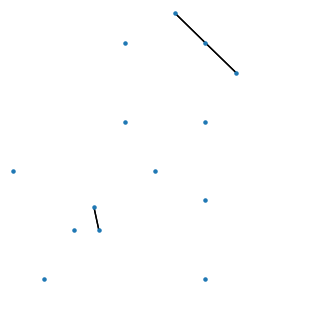

In [53]:
N = 4

fig,ax = plt.subplots(N,N,figsize=(4,4),dpi=100)




for i in range(N):
    for j in range(N):
        
        nx.draw( model().to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()

In [85]:
model.train();

In [86]:
actions = get_decision_sequence(graph_ds[5])

In [87]:
model(actions=actions)

tensor(-35.2067, grad_fn=<AddBackward0>)

In [88]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [91]:
get_decision_sequence(graph_ds[63])

[0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 3,
 1,
 0,
 0,
 4,
 0,
 2,
 1,
 1]

In [93]:
model.train()
from tqdm.notebook import tqdm
training_loss = 0
n_epochs = 25
for epoch in tqdm(range(n_epochs)):
  #print("Current epoch is %i",epoch)
  #print("training_loss in previous epoch is %f",training_loss)
  training_loss = 0
        
  for data in tqdm(graph_ds):
    actions = get_decision_sequence(data)
    #print(actions)
    optimizer.zero_grad()
    loss = -model(actions=actions)
    print(loss)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()
        
      

tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=

tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=

KeyboardInterrupt: ignored

## submit the trained model source code + saved state_dict 

In [ ]:
N = 4
model.eval()
fig,ax = plt.subplots(N,N,figsize=(4,4),dpi=100)


for i in range(N):
    for j in range(N):
        
        nx.draw( model().to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()